# Objective
To predict the type of endangered species of fish at a site, given observational data (primarily counts) of common fish

Author: Daren Eiri

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

import seaborn as sns

In [2]:
df = pd.read_csv('fish_habitat.csv')

# Previewing data
We can already see that there are some very large values for many columns as compared to the mean. Data is not normally distributed. 

In [3]:
df.describe()

,id,fish1_activity1,unique_fish_seen,fish1_activity2,fish3_count,fish2_count,fish1_count,fish3_activity1_day,fish3_activity1_night,fish3_activity2_day,fish3_activity2_night,fish3_activity3_day,fish3_activity3_night,allfish_allactivity,fish3_activity4_day,fish3_activity4_night,fish1_activity_3,fish1_allactivity
count,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.00000,2958.000000
mean,1478.500000,0.861731,51.472279,10.774848,1.212306,1.551724,48.708249,0.565923,0.325558,57.312711,3.057133,1.420554,3.165652,59.786004,0.486815,0.026031,42.76741,54.403989
std,854.045374,8.437649,933.924022,92.766524,0.548824,26.036807,933.626311,0.919603,0.996016,940.934702,53.663228,25.742887,77.485593,941.209293,0.994912,0.740855,930.49791,936.124483
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,739.250000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
50%,1478.500000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
75%,2217.750000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000
max,2957.000000,173.000000,35426.000000,1986.000000,4.000000,843.000000,35425.000000,6.000000,6.000000,35428.000000,1518.000000,1135.000000,2530.000000,35429.000000,36.000000,36.000000,35421.00000,35427.000000


Much of this data is count data, with sensor3 and salinity being ordinal. But it's not clear the meaning behind sensor3 values.

In [4]:
df.head()

,id,fish1_activity1,unique_fish_seen,fish1_activity2,fish3_count,fish2_count,fish1_count,fish3_activity1_day,fish3_activity1_night,fish3_activity2_day,...,sensor3,salinity,fish3_activity3_day,fish3_activity3_night,allfish_allactivity,fish3_activity4_day,fish3_activity4_night,fish1_activity_3,fish1_allactivity,label
0,0,0,2,0,1,1,0,1,0,0,...,Blue,Normal,1,0,2,0,0,0,0,none
1,1,1,5,4,2,0,3,1,4,7,...,Blue,Normal,2,0,10,0,0,0,5,A
2,2,0,1,0,1,0,0,0,0,0,...,Blinking,Normal,0,0,1,1,0,0,0,D
3,3,3,4,0,1,0,3,1,0,13,...,Green,Normal,0,0,14,0,0,10,13,B
4,4,0,1,0,1,0,0,1,0,0,...,Green,Normal,0,0,1,0,0,0,0,none


Checking for any null values in data

In [5]:
df.isnull().sum()

id                        0
fish1_activity1           0
unique_fish_seen          0
fish1_activity2           0
fish3_count               0
fish2_count               0
fish1_count               0
fish3_activity1_day       0
fish3_activity1_night     0
fish3_activity2_day       0
fish3_activity2_night     0
sensor3                  16
salinity                  0
fish3_activity3_day       0
fish3_activity3_night     0
allfish_allactivity       0
fish3_activity4_day       0
fish3_activity4_night     0
fish1_activity_3          0
fish1_allactivity         0
label                     0
dtype: int64

How balanced are the labels? 

In [6]:
df.label.value_counts()

D       1437
none     999
B        246
A        189
C         87
Name: label, dtype: int64

The sensor3 column is the only one with null values. Since we're not sure how to treat its values we can ignore it as a feature for now and focus on the count data. 

Let's also focus on count data that isn't totalling other columns (like fish1_allactivity), since that data is included already in other columns. 

In [7]:
cols = ['fish1_activity1', 'unique_fish_seen', 'fish1_activity2',
       'fish3_count', 'fish2_count', 'fish1_count', 'fish3_activity1_day',
       'fish3_activity1_night', 'fish3_activity2_day', 'fish3_activity2_night',
       'fish3_activity3_day', 'fish3_activity3_night',
       'fish3_activity4_day', 'fish3_activity4_night',
       'fish1_activity_3']


# Early visualizations
Generate some box plots to see the distribution of the data. Several are considered outliers.

fish1_activity1             AxesSubplot(0.125,0.84472;0.036215x0.0352804)
unique_fish_seen         AxesSubplot(0.168458,0.84472;0.036215x0.0352804)
fish1_activity2          AxesSubplot(0.211916,0.84472;0.036215x0.0352804)
fish3_count              AxesSubplot(0.255374,0.84472;0.036215x0.0352804)
fish2_count              AxesSubplot(0.298832,0.84472;0.036215x0.0352804)
fish1_count               AxesSubplot(0.34229,0.84472;0.036215x0.0352804)
fish3_activity1_day      AxesSubplot(0.385748,0.84472;0.036215x0.0352804)
fish3_activity1_night    AxesSubplot(0.429206,0.84472;0.036215x0.0352804)
fish3_activity2_day      AxesSubplot(0.472664,0.84472;0.036215x0.0352804)
fish3_activity2_night    AxesSubplot(0.516121,0.84472;0.036215x0.0352804)
fish3_activity3_day      AxesSubplot(0.559579,0.84472;0.036215x0.0352804)
fish3_activity3_night    AxesSubplot(0.603037,0.84472;0.036215x0.0352804)
fish3_activity4_day      AxesSubplot(0.646495,0.84472;0.036215x0.0352804)
fish3_activity4_night    AxesSubplot(0

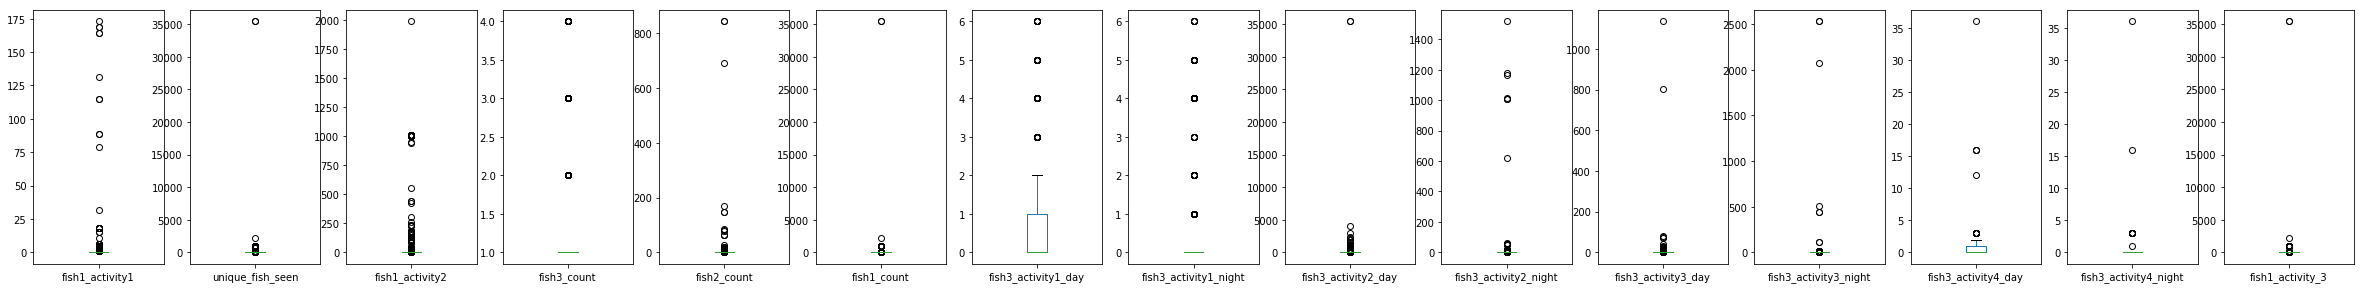

In [8]:
df[cols].plot(kind='box', subplots=True, layout=(18,18), sharex=False, sharey=False, figsize = (50,100))

Much of the data are zeros. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efca0a74cc0>,
      dtype=object)

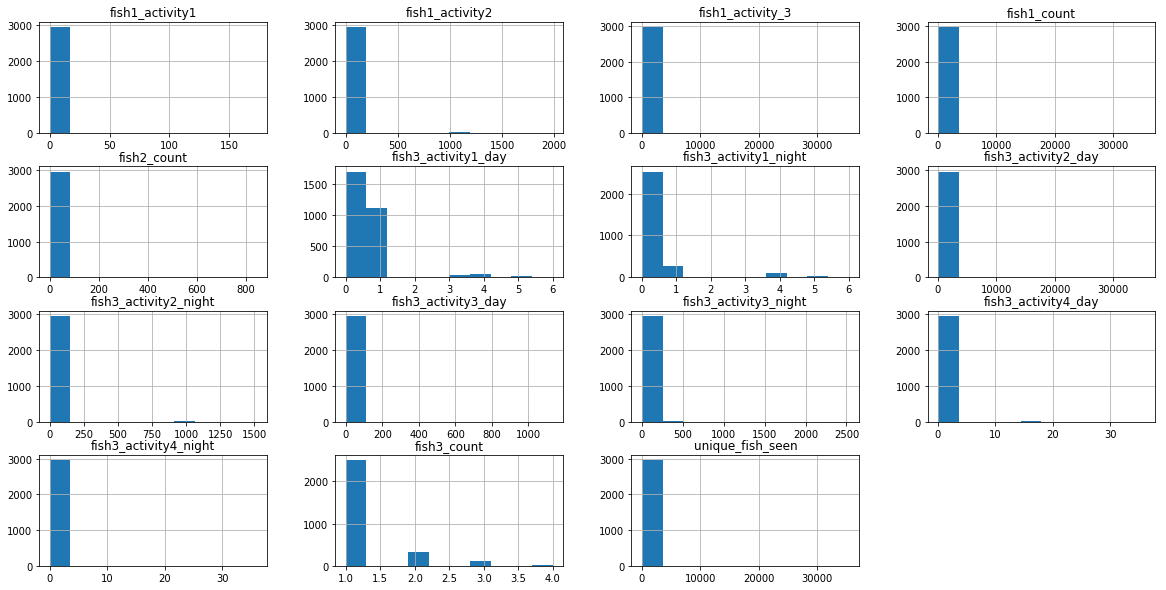

In [9]:
df.hist(column = cols, figsize= (20,10))

Are there any linear relationships in any of these columns? 

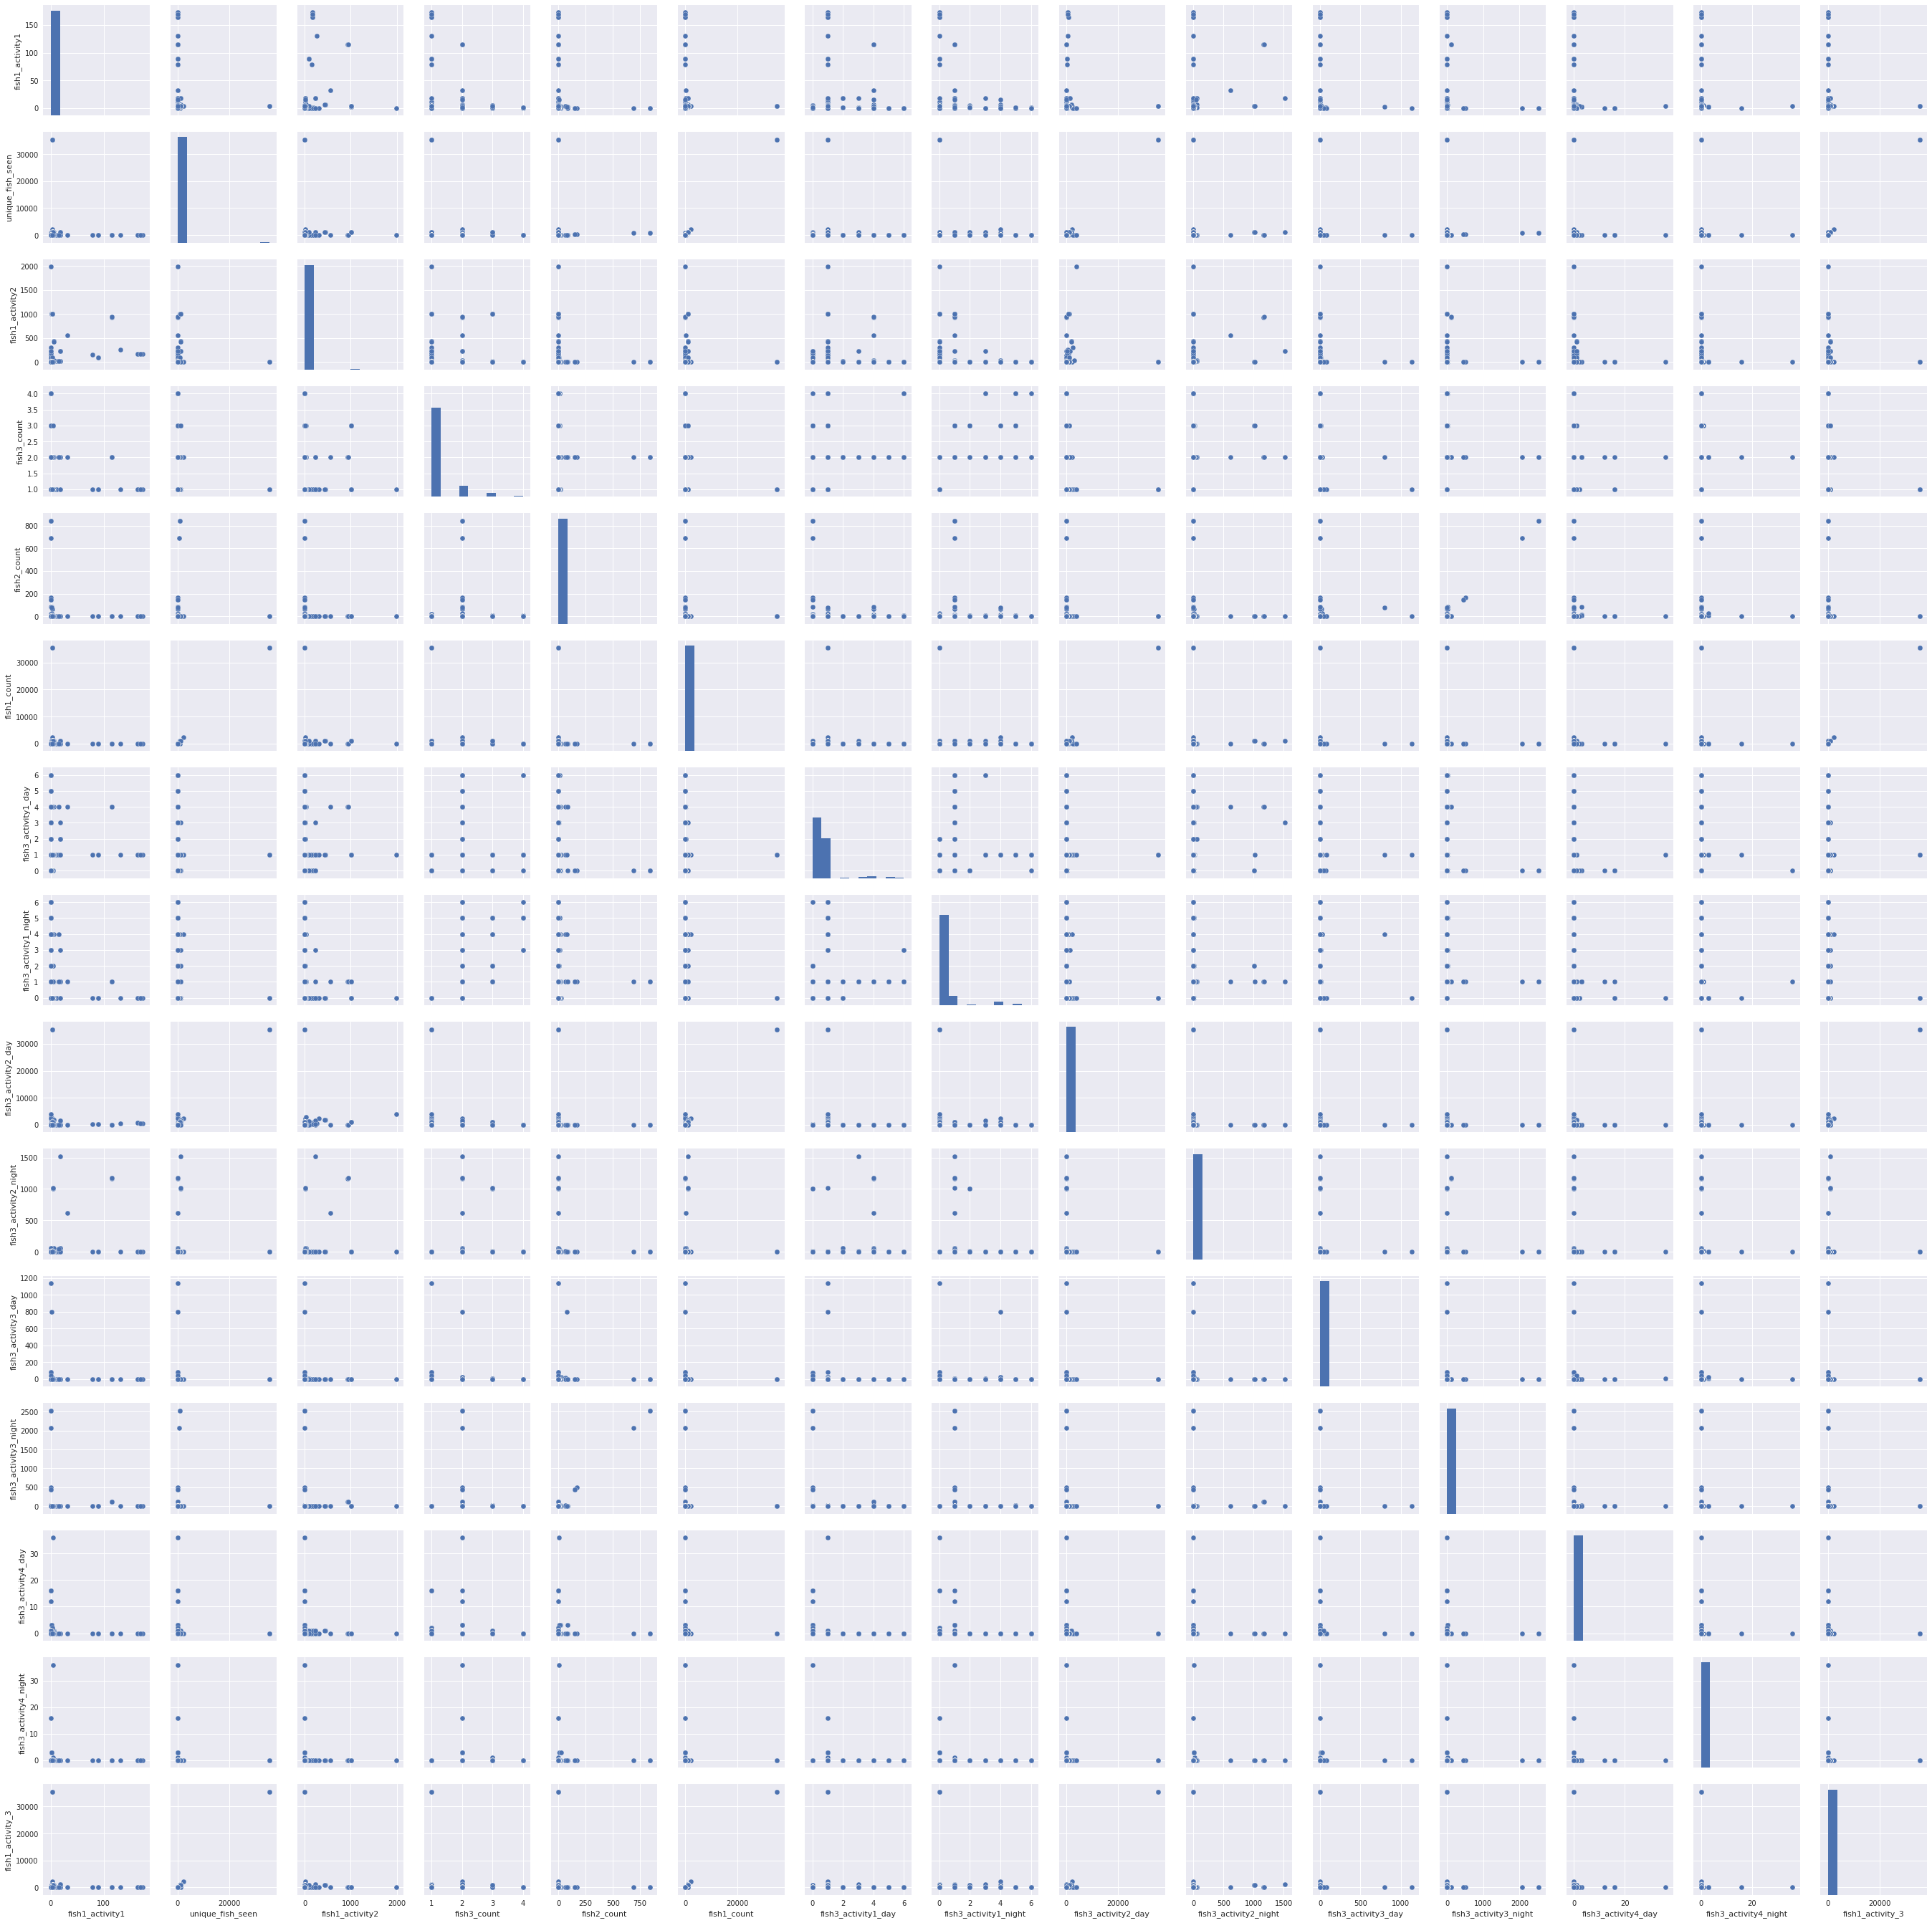

In [10]:
sns.set()
sns.pairplot(df[cols], size = 2.5)

Just exploring one of these linear relationships to see if there's any grouping by label

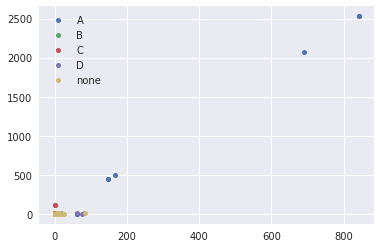

In [11]:
groups = df.groupby('label')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.fish2_count, group.fish3_activity3_night, marker='o', linestyle='', ms=5, label=name)
ax.legend()
plt.show()

# Create initial predictive model
Create feature and label sets. 
Scale features to standardize values. 
Then change labels from characters to a numeric representation.

In [12]:
X_features = df[cols]
X = scale(X_features)
y_label = df['label']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label)
print(X[:2])
print(y[:2])


[[-0.10214653 -0.05298144 -0.11616981 -0.38690259 -0.02119374 -0.05217985
   0.47210643 -0.32691516 -0.0609207  -0.0569785  -0.01633949 -0.04086163
  -0.48938776 -0.03514253 -0.04596963]
 [ 0.01638993 -0.04976865 -0.07304352  1.43548255 -0.05960741 -0.04896603
   0.47210643  3.68976204 -0.05348003 -0.0569785   0.02251276 -0.04086163
  -0.48938776 -0.03514253 -0.04596963]]
[4 0]


Split data. Set random_state to make results reproducible.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, test_size = 0.30, random_state = 7) 

In [14]:
print("The number of rows for X_train is", len(X_train))
print("The number of rows for X_test is", len(X_test))

The number of rows for X_train is 2070
The number of rows for X_test is 888


In [15]:
C_range = np.logspace(-3, 3, 6)
gamma_range = np.logspace(-3, 3, 6)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

print("Using held-out test data not used in parameter search, prediction performance is ", grid.score(X_test,y_test))

The best parameters are {'C': 1000.0, 'gamma': 63.0957344480193} with a score of 0.89
Using held-out test data not used in parameter search, prediction performance is  0.8862612612612613


## Plot confusion matrix 

Create a confusion matrix to see performance of how well the model predicts against the truth. 
The percision is decent across different groups, but the recall varies, with label A and C (which are the least represented in the dataset) having the loweset recall scores. 


In [16]:
y_pred = grid.predict(X_test)  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))


[[ 36   0   0   5  21]
 [  0  63   0   0   5]
 [  0   0  20   6   6]
 [  5   0   1 388  28]
 [  1   4   0  19 280]]
             precision    recall  f1-score   support

          A       0.86      0.58      0.69        62
          B       0.94      0.93      0.93        68
          C       0.95      0.62      0.75        32
          D       0.93      0.92      0.92       422
       none       0.82      0.92      0.87       304

avg / total       0.89      0.89      0.88       888



/usr/local/bin/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/bin/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Discussion

1. What are the characteristics of the dataset? Does anything about the dataset stand out to you?
 * What stood out the most to me was that there were a lot of zero-count data. There was also some large values outside two standard deviations from the mean for multiple columns. Consequently, the data was very right-skewed. 
 * There were also some columns that were ordinal (salinity, sensor3).
 * Some columns added up the total counts for other columns.
1. What clean-up / data preparation have you done and why?
 * Given the above, I had thought about playing around with different transformations of the data, but I decided to let SVM do this work for me.
 * I also thought about removing the single row with a very large value, but since I do not know if this data is ineeded correct, I continued on leaving this value in the dataset to have a more conservative approach. 
 * With SVM in mind, I factorized the labels so that the characters became numeric, and scaled the data to normalize the values. 
 * I focused on columns specifically related to the counts of the common fish (not the total counts) and ignored the ordinal columns for this initial predicitive model.
1. What questions would you ask the person who prepared this set?
 * Why do activity columns exists for some fish, but not for others? Was it difficult to get activity of fish2? Is fish1 only activate during the day, and fish3 at night and day? 
 * What are the details on column sensor3? What does that relate to? Is this data ordinal such that the sensor has some order of what the different statuses mean (blinking = bad; green = good?)
 * Has all the data been vetted? There is a single row with a very large value > 30000. 
1. Why did you chose the model(s) and training methods you chose?
 * I chose SVM and used a gridsearch to find the best parameters for the default SVM kernel (rbf)
 * I chose this model because of the non-linearity of the data and its implementation is relatively straight-forward. 
1. Why did you chose the evaluator you chose?
 * I evaluated the model using a confusion matrix and looking specifically at the recall-precision values because of the imbalanced dataset for the labels given.  
1. Does the model performance surprise you?
 * SVM performance in general surprises me as it is able to create a hyperplane boundary and model non-linear relationships relatively quickly. 
 * The low recall scores on labels A and C do not surprise me given that there are very few rows with this label relative to other labels. 
1. If you had one week to work on this problem what would you do?
 * I would implement some method of upsampling/downsampling the dataset so that labels are more evenly represented. Using the python package [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) comes to mind.
 * I would continue looking at additional SVM kernels (e.g., polynomial, sigmoid). 
 * Investigate performance using `svm.LinearSVC` in addition to `svm.SVC` to see how multi-class classification is different between both. 
 * Add in ordinal data (salinity, sensor3). 
 * Investigate methods using Random Forest and compare back to SVM. 


# Final Remarks

Thank you for giving me the opportunity to interview for this position. I had a lot of fun investigating this data and building an initial predictive model! I spent approximately 4 hours preparing this notebook. I spent additional time thinking about how to work with this dataset full of zero count data, as well as investigating methods to perform parameter search for the SVM model. 

I decided to approach this problem as a multi-classification prediction instead of a binary prediction because in my experience, sometimes the variability within the classes is not easily seperable when combined and the prediction performance decreases. For example, there are three classes [A, B, none] and A and B are combined so that we have a binary classification problem [1, 0]. Classes A and B themselves are very disinct, but combining them may make it less descriminant when predicting. If "monkeys" and "dogs" were classified together as "animals", there might be some challenges in classifying an image correctly, depending on what "non-animals" looks like. Whether to combine the data to do binary classification instead of multi-class classification is data-dependent. 

At the same time, having more output classes makes the model more complex. With that said, creating a binary model could improve performance and it would be interesting to see how much improvement could be made over a multiclassification problem. 